# Classification
In this notebook we classify the CT/PET scans of lung cancer cases by tumor type. 
We are doing this as a baseline task to validate our data loading pipeline.
Most code is taken from [this tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from nscl_dataset import NSCLDataSet

cudnn.benchmark = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    torch.cuda.empty_cache() 
    
cpu = torch.device("cpu")

torch.cuda.list_gpu_processes()

/dhc/home/tobias.fiedler/conda3/envs/advancedML/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'pynvml module not found, please install pynvml'

In [2]:
ds = NSCLDataSet()

In [3]:
next(iter(ds))[0].shape

torch.Size([3, 512, 512])

# Defining datasets (train/validation) 

In [4]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(32),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #transforms.Grayscale(),
])

trainSet, valSet = random_split(NSCLDataSet(transform=preprocess), [0.8, 0.2])
dataloaders = {
    "train": torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, num_workers=4),
    "val": torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=True, num_workers=4)
}

class_names = ["Adenocarcinoma", "Small Cell Carcinoma", "Large Cell Carcinoma", "Squamous Cell Carcinoma"]
num_classes = len(class_names)
dataset_sizes = {"train": len(trainSet),"val": len(valSet)}

# Defining model 

In [5]:
from capsule_net import CapsNet
from capsnet_config import Config
model = CapsNet(config = Config())


model.to(device)

CapsNet(
  (conv_layer): ConvLayer(
    (conv): Conv2d(3, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (1): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (2): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (3): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (4): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (5): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (6): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
      (7): Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (reconstraction_layers): Sequential(
      (0): Linear(in_features=64, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_featur

# Setup training

In [6]:
import tqdm

def predicted_indices_from_outputs(outputs):
    classes = torch.sqrt((outputs ** 2).sum(2))
    _, max_length_indices = classes.max(dim=1)
    return torch.squeeze(max_length_indices)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs, reconstructions, _ = model(inputs)
                    preds = predicted_indices_from_outputs(outputs)
                    loss = model.loss(inputs, outputs, labels, reconstructions)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                batch_loss = loss.item() * inputs.size(0)
                running_loss += batch_loss
                _, labels_index = torch.max(labels.data, 1)
                batch_num_correct = torch.sum(preds ==labels_index)
                running_corrects += batch_num_correct
                if idx % 10 == 0:
                    print(f"Batch {idx}/{len(dataloaders[phase])}")
                    batch_size = inputs.size(0)
                    tqdm.write("Epoch: [{}/{}], Batch: [{}/{}], train accuracy: {:.6f}, loss: {:.6f}".format(
                        epoch,
                        num_epochs,
                        idx + 1,
                        len(dataloaders[phase]),
                        batch_num_correct / float(batch_size),
                        batch_loss / float(batch_size)
                        ))
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Define training parameters

In [7]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Run training

In [8]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=6)

Epoch 0/5
----------
Batch 0/760
Batch 200/760
Batch 400/760
Batch 600/760
train Loss: 0.8670 Acc: 20.8250
Batch 0/190
val Loss: 0.8211 Acc: 21.0079

Epoch 1/5
----------
Batch 0/760
Batch 200/760
Batch 400/760
Batch 600/760
train Loss: 0.7917 Acc: 20.9975
Batch 0/190
val Loss: 0.7655 Acc: 21.0072

Epoch 2/5
----------
Batch 0/760
Batch 200/760
Batch 400/760
Batch 600/760
train Loss: 0.7463 Acc: 20.9947
Batch 0/190
val Loss: 0.7280 Acc: 21.0072

Epoch 3/5
----------
Batch 0/760
Batch 200/760
Batch 400/760
Batch 600/760
train Loss: 0.7150 Acc: 20.9947
Batch 0/190
val Loss: 0.7025 Acc: 21.0079

Epoch 4/5
----------
Batch 0/760
Batch 200/760
Batch 400/760
Batch 600/760
train Loss: 0.6931 Acc: 20.9941
Batch 0/190
val Loss: 0.6841 Acc: 21.0072

Epoch 5/5
----------
Batch 0/760
Batch 200/760
Batch 400/760
Batch 600/760
train Loss: 0.6766 Acc: 20.9941
Batch 0/190
val Loss: 0.6690 Acc: 21.0092

Training complete in 10m 47s
Best val Acc: 21.009217


In [9]:
n= 88604672

for i in range(1,100000):
    r = ((n/32)/2)%i
    t = ((n/32)/2)/i
    if r==0:
        print(i,t)

1 1384448.0
2 692224.0
4 346112.0
8 173056.0
13 106496.0
16 86528.0
26 53248.0
32 43264.0
52 26624.0
64 21632.0
104 13312.0
128 10816.0
169 8192.0
208 6656.0
256 5408.0
338 4096.0
416 3328.0
512 2704.0
676 2048.0
832 1664.0
1024 1352.0
1352 1024.0
1664 832.0
2048 676.0
2704 512.0
3328 416.0
4096 338.0
5408 256.0
6656 208.0
8192 169.0
10816 128.0
13312 104.0
21632 64.0
26624 52.0
43264 32.0
53248 26.0
86528 16.0


# Evaluation

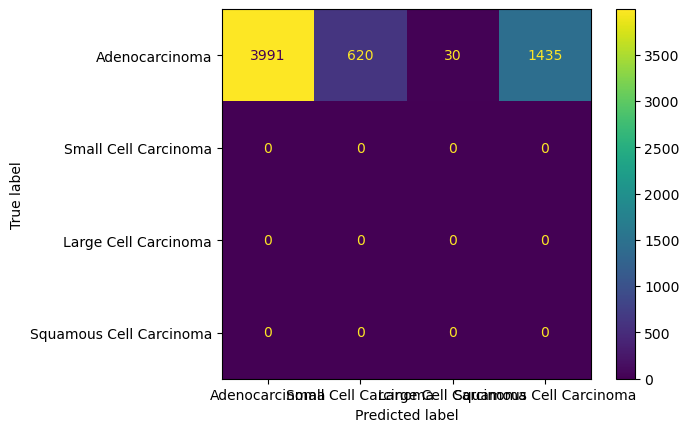

F1-score: 0.7928876527267309


In [17]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score


y_true = np.array([])
y_pred = np.array([])
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs, _, _ = model(inputs)
        
        
        preds = predicted_indices_from_outputs(outputs).cpu()
        _, labels = torch.max(classes.cpu(), 1)
    
        y_true = np.concatenate((y_true, preds))
        y_pred = np.concatenate((y_pred, labels))
        
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred), display_labels=class_names)
disp.plot()
plt.show()
print("F1-score:",f1_score(y_true, y_pred, average="weighted") )

# Debugging

In [ ]:
import torch
outputs = torch.Tensor([[0,0,1], [1,0,0], [0,1,0]])
_, preds = torch.max(outputs, 1)
labels = torch.Tensor([1, 0, 1])

print("Predictions", preds)
print("Labels", labels)

comparison = preds == labels
print("Comparison", comparison)

print("Sum", torch.sum(preds == labels))

Predictions tensor([2, 0, 1])
Labels tensor([1., 0., 1.])
Comparison tensor([False,  True,  True])
Sum tensor(2)
